## ⚗️ EDA (Exploratory Data Analysis)

### 1. 패키지 설치 및 임포트

In [1]:
import os
import random


import numpy as np
import pandas as pd
import pandas_profiling

import torch

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer


# 랜덤 시드 설정
def set_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

/tmp/ipykernel_69376/3685927287.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


### 2. 데이터 불러오기

In [2]:
DKT_PATH = '/opt/ml/input'
DATA_PATH = os.path.join(DKT_PATH, 'data')

edu_tr = pd.read_csv(os.path.join(DATA_PATH, 'train_data.csv'), parse_dates=['Timestamp'])
edu_te = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'), parse_dates=['Timestamp'])

print('edu_tr shape: ', edu_tr.shape)
print('edu_te shape: ', edu_te.shape)

edu_tr shape:  (2266586, 6)
edu_te shape:  (260114, 6)


### Data Info

In [3]:
edu_tr.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [4]:
edu_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int64         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int64         
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 103.8+ MB


In [5]:
# 편의를 위해 칼럼 이름 변경
edu_tr.columns = ['uid', 'question_id', 'test_id', 'answer', 'timestamp', 'tag']
edu_te.columns = ['uid', 'question_id', 'test_id', 'answer', 'timestamp', 'tag']

In [6]:
edu_tr.sample(5)

,uid,question_id,test_id,answer,timestamp,tag
1651640,2917,A080115002,A080000115,1,2020-11-04 05:45:17,2712
36507,49,A060097002,A060000097,1,2020-08-25 12:24:23,9931
489351,686,A020073001,A020000073,1,2020-03-13 01:29:27,7935
391310,535,A030078005,A030000078,1,2020-06-09 23:40:50,481
2131475,5036,A040164002,A040000164,1,2020-09-25 12:10:00,2122


In [7]:
edu_tr.describe()

,uid,answer,tag
count,2.266586e+06,2.266586e+06,2.266586e+06
mean,2.087687e+03,6.543784e-01,4.909007e+03
std,1.589365e+03,4.755706e-01,3.302214e+03
min,0.000000e+00,0.000000e+00,2.300000e+01
25%,8.000000e+02,0.000000e+00,1.931000e+03
50%,1.748000e+03,1.000000e+00,5.258000e+03
75%,3.046000e+03,1.000000e+00,7.913000e+03
max,7.441000e+03,1.000000e+00,1.127100e+04


In [8]:
# 복사본 생성
edu_tr_copy = edu_tr.copy()

### pandas profile

In [9]:
# profile = edu_tr.profile_report()

In [10]:
# profile.to_file(output_file='./profile.html')

## 3. EDA

🟢 : 가설 성공

🟡 : 가설 진행 중

🔴 : 가설 실패

#### 🟡 `question_id`, `test_id` 불필요한 정보 제거

test_id 첫 자리 다음 9자리 중 가운데 3자리 (000) 제거  
첫 자리 A는 나중에 숫자 타입으로 혹시 바뀔 위험으로 인해 제거하지 않음

In [11]:
edu_tr['test_id'][2266585][:4] + edu_tr['test_id'][2266585][7:]

'A040165'

In [12]:
edu_tr['test_id'] = edu_tr['test_id'].apply(lambda x: x[:4] + x[7:])
edu_te['test_id'] = edu_te['test_id'].apply(lambda x: x[:4] + x[7:])

In [13]:
edu_tr.head()

,uid,question_id,test_id,answer,timestamp,tag
0,0,A060001001,A060001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060001,1,2020-03-24 00:17:36,7225


question_id 앞 7자리 (A + 숫자 6자리) = test_id

#### 🟡 `test_id` 앞자리 가운데 숫자 (1~9) 대분류 feature인 `test_category` 생성

In [14]:
edu_tr['test_id'][0][2]

'6'

In [15]:
edu_tr['test_category'] = edu_tr['test_id'].str[2].astype('int8')
edu_te['test_category'] = edu_te['test_id'].str[2].astype('int8')

In [16]:
edu_tr.head()

,uid,question_id,test_id,answer,timestamp,tag,test_category
0,0,A060001001,A060001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060001,1,2020-03-24 00:17:36,7225,6


#### 🟡 `timestamp`을 통해 `question_lag_time` 생성 및 시간 단위 초로 변경하기

`question_lag_time` : 한 문항에서 다음 "문항"으로 넘어가는 시간

In [17]:
edu_tr.dtypes

uid                       int64
question_id              object
test_id                  object
answer                    int64
timestamp        datetime64[ns]
tag                       int64
test_category              int8
dtype: object

In [18]:
# uid와 timestamp 기준으로 정렬
edu_tr.sort_values(by=['uid', 'timestamp'], ascending=True, inplace=True)
edu_te.sort_values(by=['uid', 'timestamp'], ascending=True, inplace=True)

In [19]:
edu_tr

,uid,question_id,test_id,answer,timestamp,tag,test_category
0,0,A060001001,A060001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060001,1,2020-03-24 00:17:36,7225,6
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030071,0,2020-06-05 06:50:21,438,3
2266582,7441,A040165001,A040165,1,2020-08-21 01:06:39,8836,4
2266583,7441,A040165002,A040165,1,2020-08-21 01:06:50,8836,4
2266584,7441,A040165003,A040165,1,2020-08-21 01:07:36,8836,4


In [20]:
# https://stackoverflow.com/questions/74872281/pandas-how-i-find-the-lag-difference-days-in-treatment-for-each-patient
question_lag_time = edu_tr.groupby(['uid', 'test_id'])['timestamp'].diff().dt.seconds.fillna(0, downcast='int')
question_lag_time_te = edu_te.groupby(['uid', 'test_id'])['timestamp'].diff().dt.seconds.fillna(0, downcast='int')

In [21]:
question_lag_time

0           0
1           3
2           8
3           7
4           7
           ..
2266581    24
2266582     0
2266583    11
2266584    46
2266585    73
Name: timestamp, Length: 2266586, dtype: int64

#### 🟡 `question_lag_time` 이상치 처리  및 scale 조정하기

In [22]:
question_lag_time.quantile([0.2, 0.5, 0.85])

0.20     2.0
0.50    20.0
0.85    92.0
Name: timestamp, dtype: float64

In [23]:
question_lag_time.describe()

count    2.266586e+06
mean     2.372714e+02
std      3.165030e+03
min      0.000000e+00
25%      3.000000e+00
50%      2.000000e+01
75%      5.400000e+01
max      8.639900e+04
Name: timestamp, dtype: float64

In [24]:
edu_tr['question_lag_time'] = question_lag_time
edu_te['question_lag_time'] = question_lag_time_te

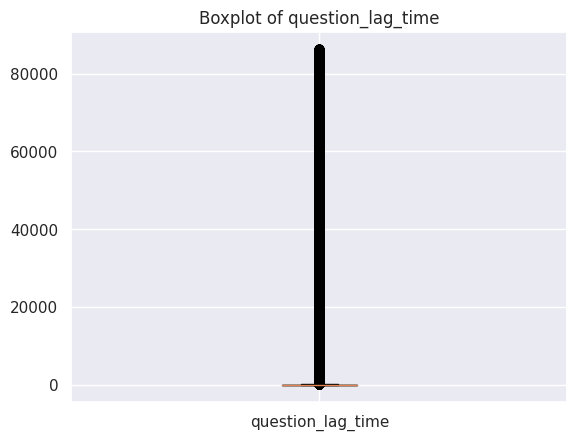

In [25]:
plt.boxplot(edu_tr['question_lag_time'])
plt.title('Boxplot of question_lag_time')
plt.xticks([1], ['question_lag_time'])
plt.show();

In [26]:
# QuantileTransformer를 통해 scale 조정
scaler_question_lag_time = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
raw_vec_question_lag_time = edu_tr.question_lag_time.values.reshape(-1, 1)

scaler_question_lag_time.fit(raw_vec_question_lag_time)

edu_tr.question_lag_time = scaler_question_lag_time.transform(raw_vec_question_lag_time).reshape(1, -1)[0]

In [27]:
# QuantileTransformer를 통해 scale 조정
scaler_question_lag_time_te = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
raw_vec_question_lag_time_te = edu_te.question_lag_time.values.reshape(-1, 1)

scaler_question_lag_time_te.fit(raw_vec_question_lag_time_te)

edu_te.question_lag_time = scaler_question_lag_time_te.transform(raw_vec_question_lag_time_te).reshape(1, -1)[0]

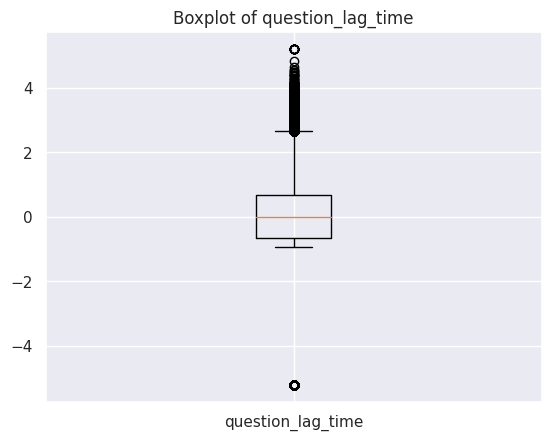

In [28]:
plt.boxplot(edu_tr['question_lag_time'])
plt.title('Boxplot of question_lag_time')
plt.xticks([1], ['question_lag_time'])
plt.show();

#### 🟡 `test_timestamp` 생성하기 

`test_timestamp` : 해당 "시험지"를 풀기 시작한 시점 feature 생성하기

In [29]:
edu_tr

,uid,question_id,test_id,answer,timestamp,tag,test_category,question_lag_time
0,0,A060001001,A060001,1,2020-03-24 00:17:11,7224,6,-5.199338
1,0,A060001002,A060001,1,2020-03-24 00:17:14,7225,6,-0.650837
2,0,A060001003,A060001,1,2020-03-24 00:17:22,7225,6,-0.403108
3,0,A060001004,A060001,1,2020-03-24 00:17:29,7225,6,-0.430727
4,0,A060001005,A060001,1,2020-03-24 00:17:36,7225,6,-0.430727
...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030071,0,2020-06-05 06:50:21,438,3,0.114185
2266582,7441,A040165001,A040165,1,2020-08-21 01:06:39,8836,4,-5.199338
2266583,7441,A040165002,A040165,1,2020-08-21 01:06:50,8836,4,-0.295415
2266584,7441,A040165003,A040165,1,2020-08-21 01:07:36,8836,4,0.559592


In [30]:
# https://stackoverflow.com/questions/41525911/group-by-pandas-dataframe-and-select-latest-in-each-group
test_timestamp = edu_tr.groupby(['uid', 'test_id']).agg(test_timestamp=('timestamp', min))
test_timestamp_te = edu_te.groupby(['uid', 'test_id']).agg(test_timestamp=('timestamp', min))

In [31]:
test_timestamp

test_timestamp
uid  test_id                    
0    A020172 2020-10-11 11:06:47
     A020174 2020-10-17 10:56:12
     A020181 2020-10-18 09:33:27
     A020182 2020-10-21 10:11:49
     A020183 2020-10-22 09:19:40
...                          ...
7440 A030136 2020-09-23 09:19:35
     A030197 2020-10-21 08:31:45
     A050096 2020-08-19 04:57:19
7441 A030071 2020-06-05 06:46:41
     A040165 2020-08-21 01:06:39

[365164 rows x 1 columns]

In [32]:
test_timestamp.reset_index(inplace=True)
test_timestamp

,uid,test_id,test_timestamp
0,0,A020172,2020-10-11 11:06:47
1,0,A020174,2020-10-17 10:56:12
2,0,A020181,2020-10-18 09:33:27
3,0,A020182,2020-10-21 10:11:49
4,0,A020183,2020-10-22 09:19:40
...,...,...,...
365159,7440,A030136,2020-09-23 09:19:35
365160,7440,A030197,2020-10-21 08:31:45
365161,7440,A050096,2020-08-19 04:57:19
365162,7441,A030071,2020-06-05 06:46:41


In [33]:
test_timestamp_te.reset_index(inplace=True)

In [34]:
# 기존 edu_tr과 test_timestamp 합치기
edu_tr = pd.merge(left=edu_tr, right=test_timestamp, how='left', on=['uid', 'test_id'], sort=True)
edu_te = pd.merge(left=edu_te, right=test_timestamp_te, how='left', on=['uid', 'test_id'], sort=True)

In [35]:
edu_tr.head()

,uid,question_id,test_id,answer,timestamp,tag,test_category,question_lag_time,test_timestamp
0,0,A020172001,A020172,1,2020-10-11 11:06:47,8132,2,-5.199338,2020-10-11 11:06:47
1,0,A020172002,A020172,1,2020-10-11 11:06:56,8132,2,-0.362241,2020-10-11 11:06:47
2,0,A020172003,A020172,1,2020-10-11 11:07:13,8132,2,-0.088734,2020-10-11 11:06:47
3,0,A020172004,A020172,1,2020-10-11 11:07:46,8132,2,0.335333,2020-10-11 11:06:47
4,0,A020172005,A020172,0,2020-10-11 11:08:20,8132,2,0.348756,2020-10-11 11:06:47


#### 🟡 `test_lag_time` 생성하기 및 scale 조정하기 

`test_lag_time` : 한 "시험지"에서 다음 "시험지"로 넘어가는 시간  
앞서, `question_lag_time`은 seconds 기준이었다면, `test_lag_time`은 hour 기준으로.

In [36]:
# uid와 test_timestamp 기준으로 정렬
edu_tr.sort_values(by=['uid', 'test_timestamp'], ascending=True, inplace=True)
edu_te.sort_values(by=['uid', 'test_timestamp'], ascending=True, inplace=True)

In [37]:
test_lag_time = edu_tr.groupby('uid')['test_timestamp'].diff().dt.total_seconds() // 3600
test_lag_time_te = edu_te.groupby('uid')['test_timestamp'].diff().dt.total_seconds() // 3600

In [38]:
test_lag_time

36            NaN
37            0.0
38            0.0
39            0.0
40            0.0
            ...  
2266581       0.0
2266582    1842.0
2266583       0.0
2266584       0.0
2266585       0.0
Name: test_timestamp, Length: 2266586, dtype: float64

In [39]:
test_lag_time.replace(0, np.NaN, inplace=True) # 0을 결측값으로 변경
test_lag_time.fillna(method='pad', inplace=True) # 결측값을 앞 방향으로 채우기
test_lag_time.fillna(0, inplace=True) 

In [40]:
test_lag_time_te.replace(0, np.NaN, inplace=True) # 0을 결측값으로 변경
test_lag_time_te.fillna(method='pad', inplace=True) # 결측값을 앞 방향으로 채우기
test_lag_time_te.fillna(0, inplace=True) 

In [41]:
test_lag_time.isnull().sum()

0

In [42]:
test_lag_time.quantile([0.2, 0.5, 0.95])

0.20     20.0
0.50     47.0
0.95    311.0
Name: test_timestamp, dtype: float64

In [43]:
test_lag_time.clip(lower=0, upper=300, inplace=True)
test_lag_time_te.clip(lower=0, upper=300, inplace=True)

In [44]:
test_lag_time.describe()

count    2.266586e+06
mean     7.252383e+01
std      7.553990e+01
min      0.000000e+00
25%      2.200000e+01
50%      4.700000e+01
75%      9.600000e+01
max      3.000000e+02
Name: test_timestamp, dtype: float64

In [45]:
edu_tr['test_lag_time'] = test_lag_time
edu_te['test_lag_time'] = test_lag_time_te

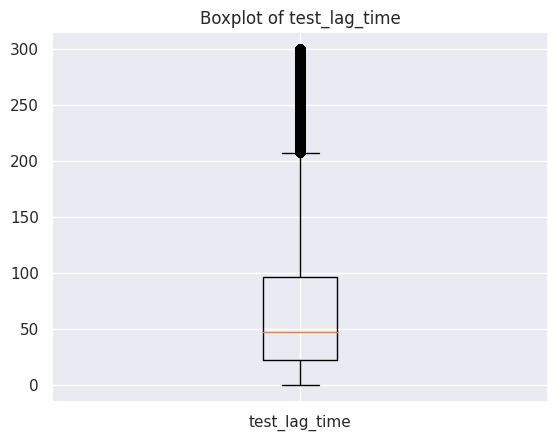

In [46]:
plt.boxplot(edu_tr['test_lag_time'])
plt.title('Boxplot of test_lag_time')
plt.xticks([1], ['test_lag_time'])
plt.show();

In [47]:
# QuantileTransformer를 통해 scale 조정
scaler_test_lag_time = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
raw_vec_test_lag_time = edu_tr.test_lag_time.values.reshape(-1, 1)

scaler_test_lag_time.fit(raw_vec_test_lag_time)

edu_tr.test_lag_time = scaler_test_lag_time.transform(raw_vec_test_lag_time).reshape(1, -1)[0]

In [48]:
scaler_test_lag_time_te = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
raw_vec_test_lag_time_te = edu_te.test_lag_time.values.reshape(-1, 1)

scaler_test_lag_time_te.fit(raw_vec_test_lag_time_te)

edu_te.test_lag_time = scaler_test_lag_time_te.transform(raw_vec_test_lag_time_te).reshape(1, -1)[0]

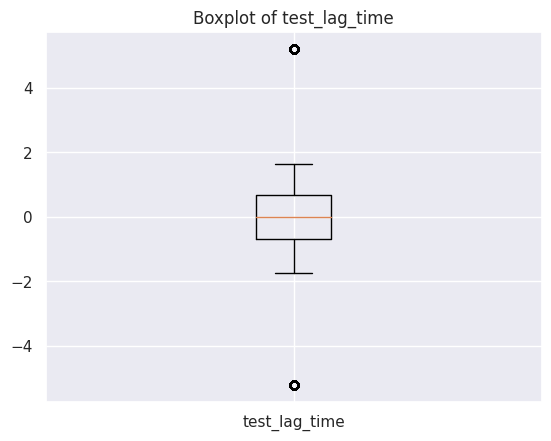

In [49]:
plt.boxplot(edu_tr['test_lag_time'])
plt.title('Boxplot of test_lag_time')
plt.xticks([1], ['test_lag_time'])
plt.show();

#### 🟡 `avg_answer` 총 문제 푼 수 대비 맞춘 점수 feature 생성하기

In [50]:
ans_cumsum = edu_tr.groupby('uid')['answer'].cumsum()
ans_cumcount = edu_tr.groupby('uid')['answer'].cumcount() + 1

avg_answer = round(ans_cumsum/ans_cumcount*100).astype(np.int32)
avg_answer[:10]

36    100
37    100
38    100
39    100
40    100
41    100
42     86
43     88
44     89
45     90
dtype: int32

In [51]:
ans_cumsum_te = edu_te.groupby('uid')['answer'].cumsum()
ans_cumcount_te = edu_te.groupby('uid')['answer'].cumcount() + 1

avg_answer_te = round(ans_cumsum_te/ans_cumcount_te*100).astype(np.int32)

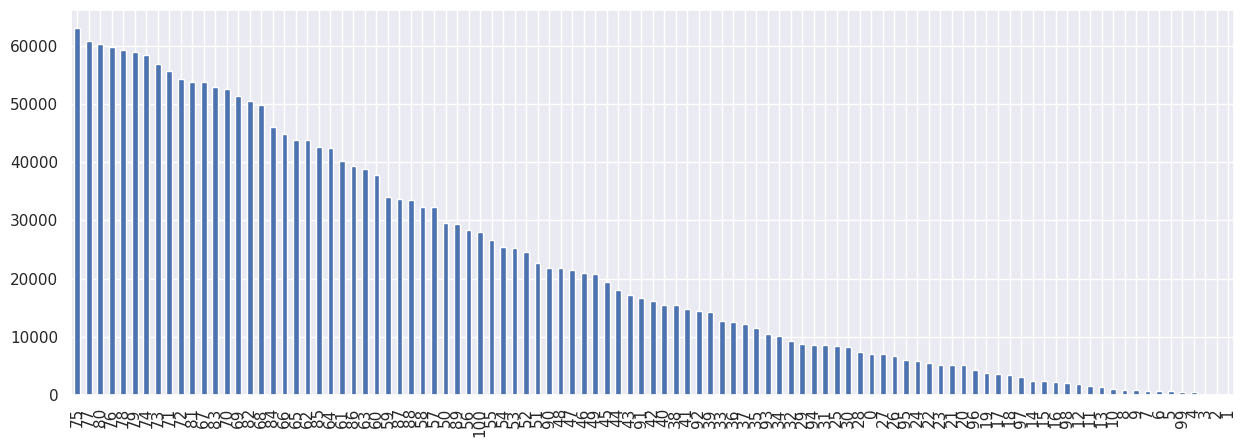

In [52]:
plt.figure(figsize=(15, 5))
avg_answer.value_counts().plot(kind='bar');

In [53]:
avg_answer.describe()

count    2.266586e+06
mean     6.616383e+01
std      1.809117e+01
min      0.000000e+00
25%      5.600000e+01
50%      7.000000e+01
75%      7.900000e+01
max      1.000000e+02
dtype: float64

In [54]:
def avg_answer_map(x: int) -> int:
    if x < 10:
        return 1
    elif x < 20:
        return 2
    elif x < 30:
        return 3
    elif x < 40:
        return 4
    elif x < 50:
        return 5
    elif x < 60:
        return 6
    elif x < 70:
        return 7
    elif x < 80:
        return 8
    elif x < 90:
        return 9
    else:
        return 10

In [55]:
edu_tr['avg_answer'] = avg_answer.apply(avg_answer_map)
edu_te['avg_answer'] = avg_answer_te.apply(avg_answer_map)

In [56]:
edu_tr

,uid,question_id,test_id,answer,timestamp,tag,test_category,question_lag_time,test_timestamp,test_lag_time,avg_answer
36,0,A060001001,A060001,1,2020-03-24 00:17:11,7224,6,-5.199338,2020-03-24 00:17:11,-5.199338,10
37,0,A060001002,A060001,1,2020-03-24 00:17:14,7225,6,-0.650837,2020-03-24 00:17:11,-5.199338,10
38,0,A060001003,A060001,1,2020-03-24 00:17:22,7225,6,-0.403108,2020-03-24 00:17:11,-5.199338,10
39,0,A060001004,A060001,1,2020-03-24 00:17:29,7225,6,-0.430727,2020-03-24 00:17:11,-5.199338,10
40,0,A060001005,A060001,1,2020-03-24 00:17:36,7225,6,-0.430727,2020-03-24 00:17:11,-5.199338,10
...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030071,0,2020-06-05 06:50:21,438,3,0.114185,2020-06-05 06:46:41,5.199338,3
2266582,7441,A040165001,A040165,1,2020-08-21 01:06:39,8836,4,-5.199338,2020-08-21 01:06:39,5.199338,4
2266583,7441,A040165002,A040165,1,2020-08-21 01:06:50,8836,4,-0.295415,2020-08-21 01:06:39,5.199338,5
2266584,7441,A040165003,A040165,1,2020-08-21 01:07:36,8836,4,0.559592,2020-08-21 01:06:39,5.199338,6


#### 🟡 LabelEncoding

In [57]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_cols_list = ['question_id', 'test_id', 'tag']

In [58]:
edu_tr[cat_cols_list] = edu_tr[cat_cols_list].apply(le.fit_transform)
edu_te[cat_cols_list] = edu_te[cat_cols_list].apply(le.fit_transform)

In [59]:
edu_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266586 entries, 36 to 2266585
Data columns (total 11 columns):
 #   Column             Dtype         
---  ------             -----         
 0   uid                int64         
 1   question_id        int64         
 2   test_id            int64         
 3   answer             int64         
 4   timestamp          datetime64[ns]
 5   tag                int64         
 6   test_category      int8          
 7   question_lag_time  float64       
 8   test_timestamp     datetime64[ns]
 9   test_lag_time      float64       
 10  avg_answer         int64         
dtypes: datetime64[ns](2), float64(2), int64(6), int8(1)
memory usage: 192.4 MB


In [60]:
edu_tr

,uid,question_id,test_id,answer,timestamp,tag,test_category,question_lag_time,test_timestamp,test_lag_time,avg_answer
36,0,5354,975,1,2020-03-24 00:17:11,556,6,-5.199338,2020-03-24 00:17:11,-5.199338,10
37,0,5355,975,1,2020-03-24 00:17:14,557,6,-0.650837,2020-03-24 00:17:11,-5.199338,10
38,0,5356,975,1,2020-03-24 00:17:22,557,6,-0.403108,2020-03-24 00:17:11,-5.199338,10
39,0,5357,975,1,2020-03-24 00:17:29,557,6,-0.430727,2020-03-24 00:17:11,-5.199338,10
40,0,5358,975,1,2020-03-24 00:17:36,557,6,-0.430727,2020-03-24 00:17:11,-5.199338,10
...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,2373,456,0,2020-06-05 06:50:21,58,3,0.114185,2020-06-05 06:46:41,5.199338,3
2266582,7441,3909,748,1,2020-08-21 01:06:39,720,4,-5.199338,2020-08-21 01:06:39,5.199338,4
2266583,7441,3910,748,1,2020-08-21 01:06:50,720,4,-0.295415,2020-08-21 01:06:39,5.199338,5
2266584,7441,3911,748,1,2020-08-21 01:07:36,720,4,0.559592,2020-08-21 01:06:39,5.199338,6


#### 🟡 `timestamp` int형으로 변환하기

In [61]:
edu_tr.timestamp = edu_tr.timestamp.apply(lambda x:x.value)
edu_te.timestamp = edu_te.timestamp.apply(lambda x:x.value)

In [62]:
edu_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266586 entries, 36 to 2266585
Data columns (total 11 columns):
 #   Column             Dtype         
---  ------             -----         
 0   uid                int64         
 1   question_id        int64         
 2   test_id            int64         
 3   answer             int64         
 4   timestamp          int64         
 5   tag                int64         
 6   test_category      int8          
 7   question_lag_time  float64       
 8   test_timestamp     datetime64[ns]
 9   test_lag_time      float64       
 10  avg_answer         int64         
dtypes: datetime64[ns](1), float64(2), int64(7), int8(1)
memory usage: 192.4 MB


## Save file

In [64]:
version = input()
edu_tr.to_csv(f'../data/train_data_ws_{version}.csv', index=False)

In [65]:
version = input()
edu_te.to_csv(f'../data/test_data_ws_{version}.csv', index=False)